In [1]:
# Basic data and viz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import io
import base64

# Dash stuff
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Output, Input

# FbProphet
import json
from fbprophet.serialize import model_to_json, model_from_json


In [ ]:
# Importing Previously Trained Model
with open('initial_prophet_model.json', 'r') as fin:
    model = model_from_json(json.load(fin))  # Load model

In [ ]:
for year in range(2015,2021):
    data[data['year'] == year]['AIL_DEMAND'].plot(kind='density', figsize = (12,7), legend = True, label = year)
_ = plt.xlabel('Energy consumption')
_ = plt.title('Variation in Distribution of Energy consumption over 5 years (2015-2020)')

In [ ]:
month_peaks = data.resample('M', label = 'left')['AIL_DEMAND'].max()
month_avg = data.resample('M', label = 'left')['AIL_DEMAND'].mean()
month_troughs = data.resample('M', label = 'left')['AIL_DEMAND'].min()

_ = plt.figure(figsize = (15,6))

month_peaks.plot( label = "Max", legend = True)
month_avg.plot(label = "Average", legend = True)
month_troughs.plot( label = "Min", legend = True)

_ = plt.title("Monthly Averages, Maximum and Minimum Demand")

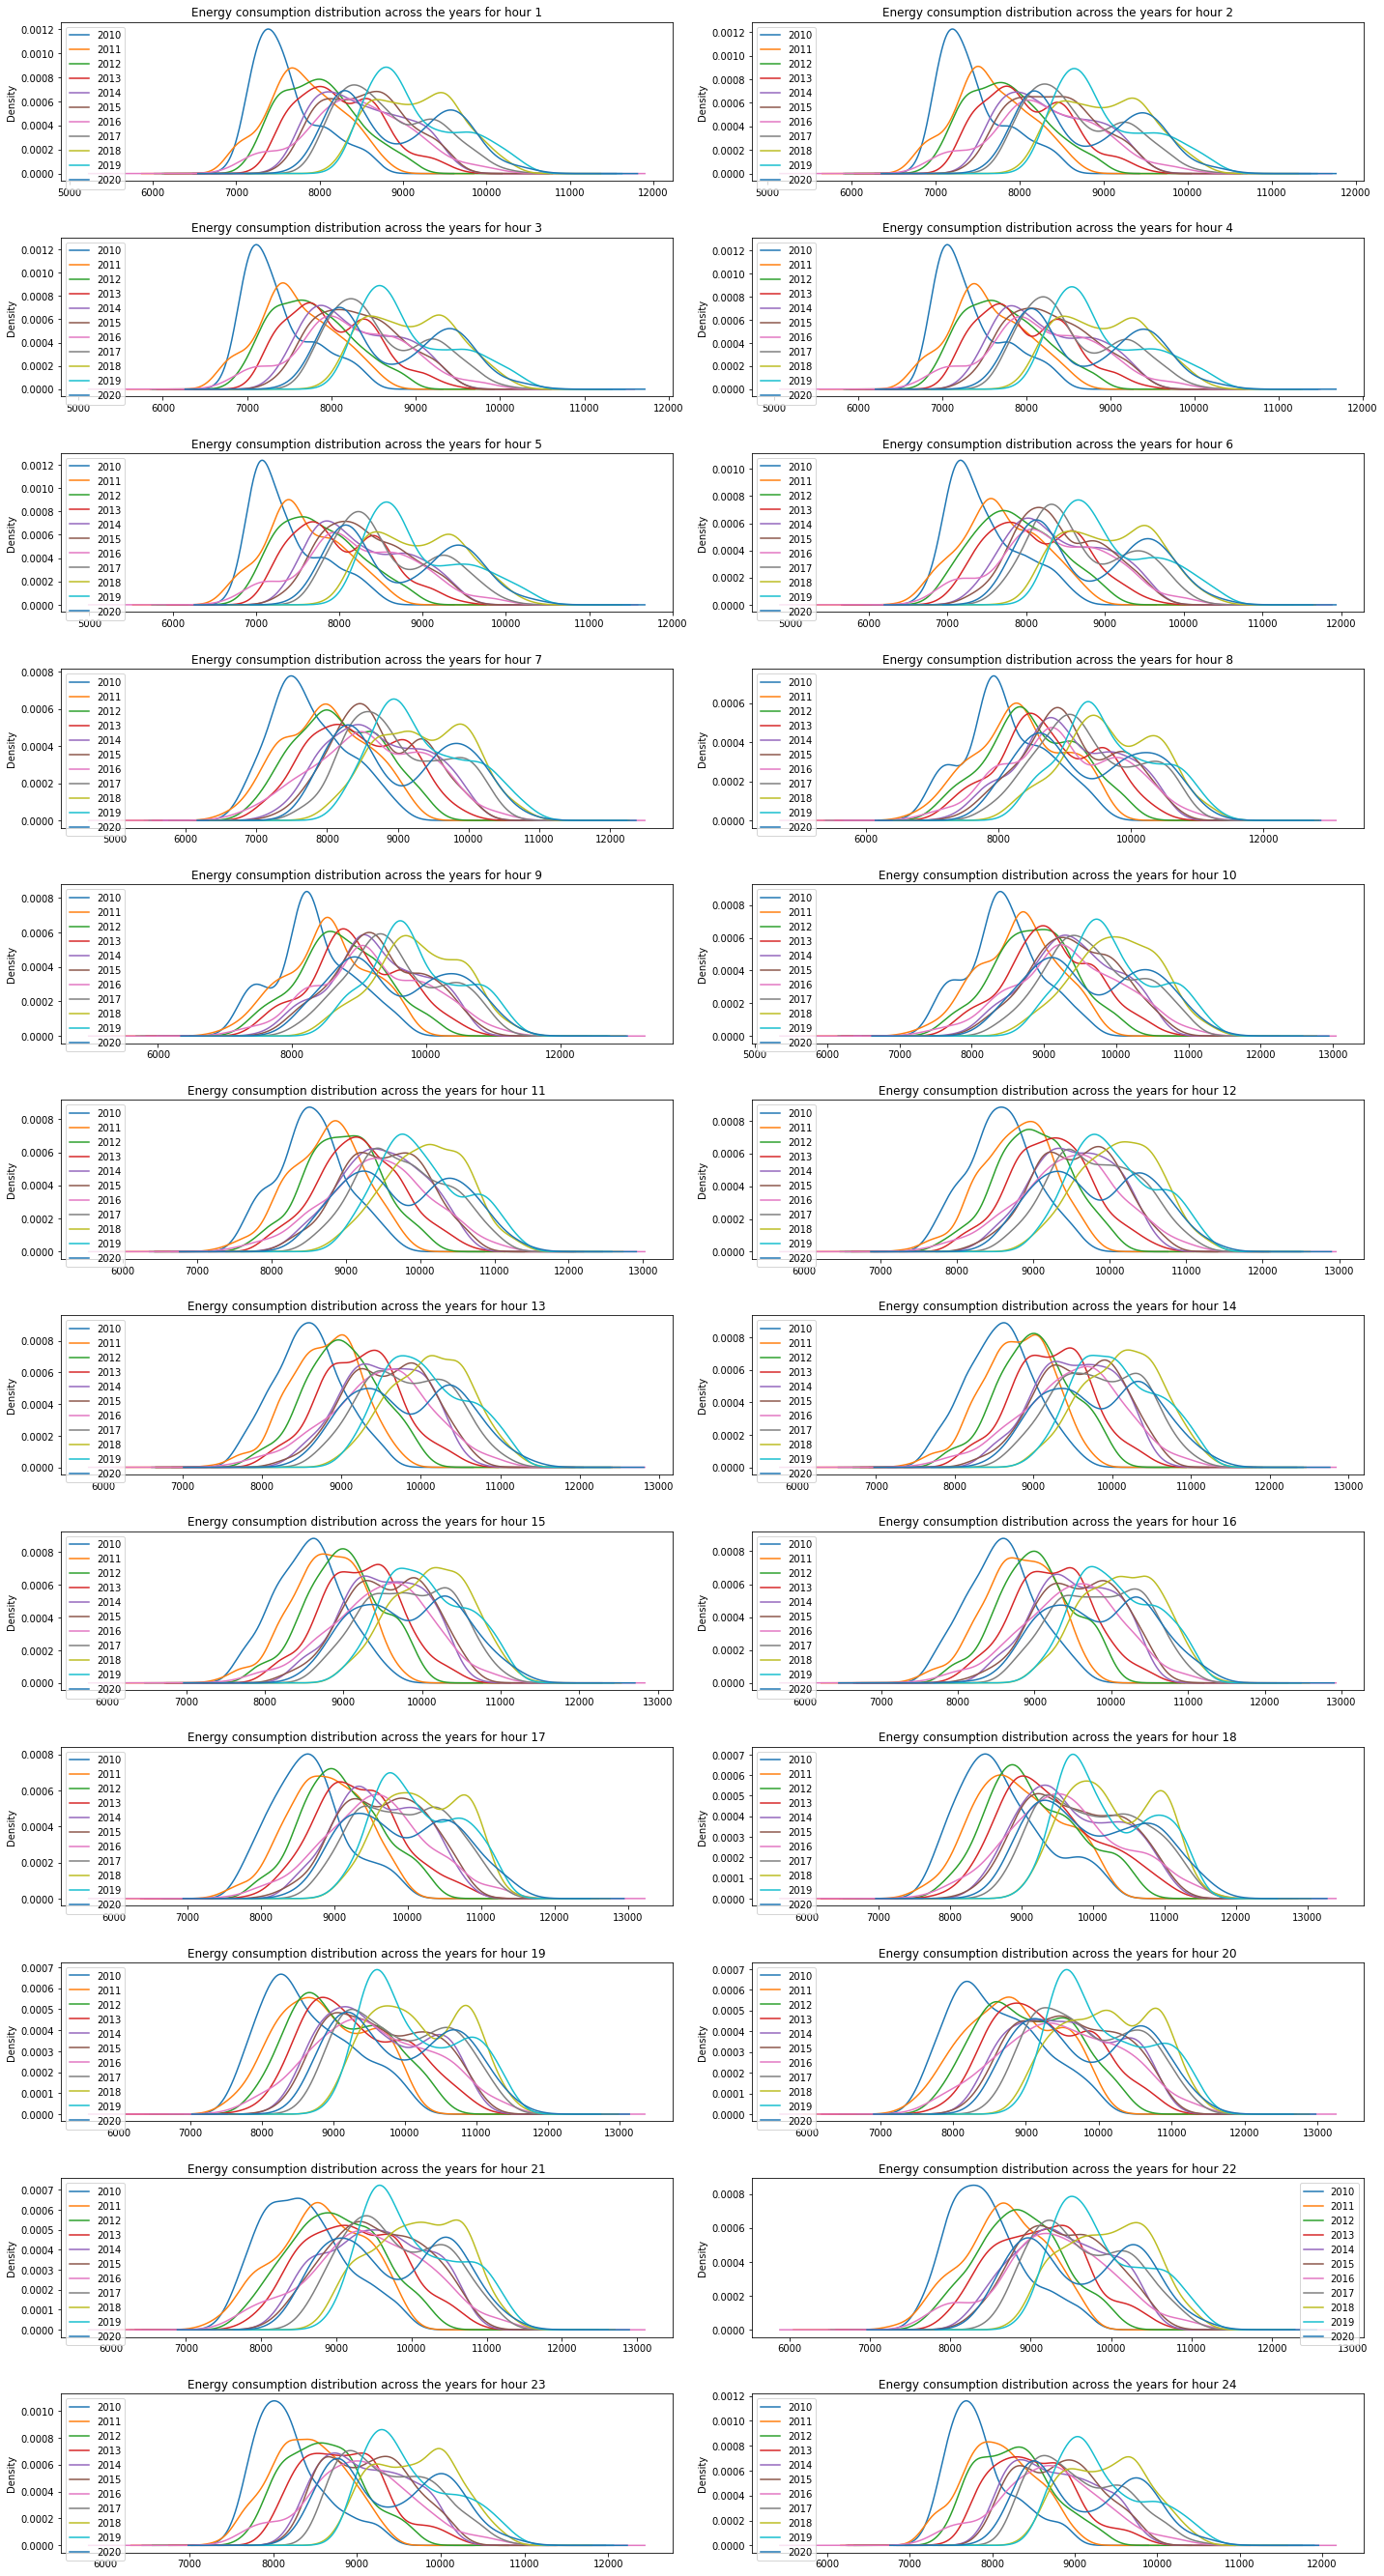

In [4]:
f = plt.figure(figsize = (20,40))
peak_hours = np.arange(0,24) 
for i, hour in enumerate(peak_hours) :
    ax = f.add_subplot(13,2,i+1)
    for j, year in enumerate(data['year'].unique()):
        data[(data['year'] == year) & (data['HE'] == str(hour+1)) ]['AIL_DEMAND'].\
                                plot(kind='density',  sharey=False, legend=True, label= year)
    plt.title('Energy consumption distribution across the years for hour '+ str(hour + 1))
    #plt.xlim(np.min(data.SDGE.values), np.max(data.SDGE.values))
plt.tight_layout()

In [2]:

# Reading in data
data = pd.read_csv("msa_merged_data.csv")
data["BEGIN_DATE_GMT"] = pd.to_datetime(data["BEGIN_DATE_GMT"])
data["Weighted_Avg_Temp.1_hour_lag"] = data["Weighted_Avg_Temp"].shift(1)
data['year'] = data['BEGIN_DATE_GMT'].dt.year
data.set_index("BEGIN_DATE_GMT", drop = False, inplace=True)
data.head()

app = dash.Dash()

#fig = px".histogram(data, x ="AIL_DEMAND", facet_row = "year", height = 2400)


app.layout = html.Div(children=[
    html.H1(children='Electricity Demand in Alberta 2010-2020',
             className = "header-title"),
    
    html.H2(children="Exploratory Analysis"),
    html.Div(
        children = [
            html.H3(children = "Choose Time Range") ,
            dcc.DatePickerRange(
                        id="summary-date-range",
                        min_date_allowed=data["BEGIN_DATE_GMT"].min().date(),
                        max_date_allowed=data["BEGIN_DATE_GMT"].max().date(),
                        start_date = data["BEGIN_DATE_GMT"].min().date(),
                        end_date=data["BEGIN_DATE_GMT"].max().date(),
            )], 
                className = "menu"
            ),
    html.Div(
        children = [
            html.Div(children = 
                dcc.Graph(
                    id='demand-dist-by-year') , 
                    className = "card"
                ),
            html.Div(children = 
                dcc.Graph(
                    id='demand-dist-by-hour') , 
                    className = "card"
                ),
            ], 
        className = "wrapper"),
    ]
)

@app.callback(
    [Output('demand-dist-by-year', 'figure'), Output('demand-dist-by-hour', 'figure')],
    [Input("summary-date-range", "start_date"),
    Input("summary-date-range", "end_date")]
    )
def update_summary_figures(start_date, end_date):
    condition = (data["BEGIN_DATE_GMT"]>= start_date) & (data["BEGIN_DATE_GMT"] <= end_date)

    filtered_data = data[ condition ]

    demand_dist_by_year_fig = go.Figure()

    for y in range( filtered_data.year.min() , filtered_data.year.max() + 1):
        demand_dist_by_year_fig.add_trace(go.Violin(
                                y =  filtered_data[filtered_data["year"] == y]["AIL_DEMAND"],
                                name= y, 
                                box_visible = True,
                                meanline_visible = True))

    demand_dist_by_year_fig.update_layout(width=800, height=500,
        title_text="Alberta Internal Load")

    demand_dist_by_year_fig.update_layout(transition_duration=500)

    demand_dist_by_hour_fig = px.histogram(filtered_data, x = "AIL_DEMAND",
                                            title='Histogram of Demand by Hour',
                                            facet_col = "HE", color = "year",
                                            opacity = 0.2,
                                            facet_col_wrap = 4,
                                            facet_col_spacing=0.01,
                                            facet_row_spacing=0.01,
                                            height = 1200,
                                            nbins = 20
                                            )

    return demand_dist_by_year_fig, demand_dist_by_hour_fig

app.run_server(host='127.0.0.1', port=8000, debug=False)

Dash is running on http://127.0.0.1:8000/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:8000/ (Press CTRL+C to quit)
127.0.0.1 - - [26/Mar/2021 13:18:19] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Mar/2021 13:18:19] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [26/Mar/2021 13:18:19] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [26/Mar/2021 13:18:20] "GET /_favicon.ico?v=1.19.0 HTTP/1.1" 200 -
127.0.0.1 - - [26/Mar/2021 13:18:20] "GET /_dash-component-suites/dash_core_components/async-datepicker.v1_15_0m1611086576.js HTTP/1.1" 200 -
127.0.0.1 - - [26/Mar/2021 13:18:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [26/Mar/2021 13:19:27] "POST /_dash-update-component HTTP/1.1" 200 -


In [ ]:
# Reading in data
data = pd.read_csv("msa_merged_data.csv")
data["BEGIN_DATE_GMT"] = pd.to_datetime(data["BEGIN_DATE_GMT"])
data["Weighted_Avg_Temp.1_hour_lag"] = data["Weighted_Avg_Temp"].shift(1)
data['year'] = data['BEGIN_DATE_GMT'].dt.year
data.set_index("BEGIN_DATE_GMT", drop = False, inplace=True)
data.head()

app = dash.Dash()


demand_dist_by_year = go.Figure()

for y in range( data.year.min() , data.year.max() + 1):
    demand_dist_by_year.add_trace(go.Violin(
                            y =  data[data["year"] == y]["AIL_DEMAND"],
                            name= y, 
                            box_visible = True,
                            meanline_visible = True))

demand_dist_by_year.update_layout(width=800, height=500,
    title_text="Alberta Internal Load")

demand_dist_by_hour = px.box(data, x = "AIL_DEMAND",
                                        title='Histogram of Consumption by Hour',
                                        facet_col = "HE", color = "year",
                                        facet_col_wrap = 4,
                                        facet_col_spacing=0.01,
                                        facet_row_spacing=0.01,
                                        height = 1200
                                        )
data_daily_avg = data.resample("D").mean()

# Temp vs. Consumption Line Graph
temp_v_demand_line = make_subplots(specs=[[{"secondary_y": True}]])
temp_v_demand_line.add_trace( go.Line( x= data_daily_avg.index,
                                y = data_daily_avg["AIL_DEMAND"], 
                                name = "Temperature"
                                ), secondary_y=False)
temp_v_demand_line.add_trace( go.Line( x= data_daily_avg.index,
                                y = data_daily_avg["Weighted_Avg_Temp"], 
                                name = "Electricity Consumption"
                                ), secondary_y=True)

temp_v_demand_line.update_layout(width=1200, height=500,
    title_text="Daily Average Temperature vs. Consumption from 2010 - 2020")
# Set x-axis title
temp_v_demand_line.update_xaxes(title_text="Time")

# Set y-axes titles
temp_v_demand_line.update_yaxes(title_text="Electricity Consumption", secondary_y=False)
temp_v_demand_line.update_yaxes(title_text="Temperature", secondary_y=True)

# Temp vs. Consumption Scatter Plot
temp_v_demand_scatter = px.scatter(data_daily_avg, x= "Weighted_Avg_Temp",
                                y = "AIL_DEMAND", 
                                title = "Temperature vs. Consumption"
                                )

app.layout = html.Div(children=[
    html.H1(children='Exploring lectricity Consumption in Alberta 2010-2020',
             className = "header-title"),
    
    html.H2(children="Alberta Internal Load"),
    html.Div(
        children = [
            html.Div(children = 
                dcc.Graph(figure = demand_dist_by_year, 
                    id='demand-dist-by-year') , 
                    className = "card"
                ),
            html.Div(children = 
                dcc.Graph(figure = demand_dist_by_hour,
                    id='demand-dist-by-hour') , 
                    className = "card"
                ),
            ], 
        className = "wrapper"),

        html.H2(children="Relationship between Demand and Temperature"),
        html.Div(
            children = [
                html.Div(children = 
                dcc.Graph(figure = temp_v_demand_line,
                    id='temp-v-demand-line') , 
                    className = "card"
                ),
                html.Div(children = 
                dcc.Graph(figure = temp_v_demand_scatter,
                    id='temp-v-demand-scatter') , 
                    className = "card"
                ),
                ], 
            className = "wrapper"),
    ]
)


app.run_server(host='127.0.0.1', port=8000, debug=False)